# Comparison of meteorologic data and bike rental system usage

The goal of this notebook is to find out if there is any dependency between the weather and poopularity of data sharing system.

The analysis will be performed comparing two cities, in this case Bonn and Leipzig but this may be changed, on both historical data from 2019 and newly collected from 2022. 

In [1]:
import pandas as pd
import os
import json
from datetime import datetime,timedelta
from tqdm import tqdm
import numpy as np
import itertools
import meteostat
from API.utils import get_postgres_engine
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('API')
from API.transform_historical_data import get_weather_data
from API import get_data_from_api, transform_api_data

plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['font.size'] = 17

Data loading

In [2]:
engine = get_postgres_engine('API/postgres_credentials.ini')

In [3]:
client = get_data_from_api.create_mong_client()

In [4]:
db = client['bda']

In [5]:
city = 'Bonn'

In [6]:
df_city = pd.read_sql(f"SELECT *, (timestamp_end - INTERVAL '150 SECONDS') as timestamp"
                      f" FROM intervals_usage WHERE city_name = '{city}'", con=engine)

In [7]:
weather_city = pd.read_sql(f"SELECT * FROM weather_data WHERE city_name = 'Hoboken'", con=engine)

In [8]:
weather_city['prcp'].any()

True

In [9]:
weather_city = pd.read_sql(f"SELECT * FROM weather_data WHERE city_name = '{city}'", con=engine)

In [10]:
def read_city_data_mongo(city):    
    r = db.bikes.aggregate([
          {"$unwind":"$countries"},
          {"$unwind":"$countries.cities"}, 
          {"$match":
           {"countries.cities.name": city}
          }
    ])
    mongo_dfs = [pd.DataFrame(transform_api_data.add_timestamp_to_dict(r_t)) for r_t in r]
    new_data_df = pd.concat(mongo_dfs)
    new_data_df = transform_api_data.add_related_columns(new_data_df)
    api_data = new_data_df.apply(transform_api_data.calculate_usage, axis=1, result_type='expand')
    return api_data

In [11]:
api_data = read_city_data_mongo(city)

In [12]:
api_data_valid = api_data.loc[api_data['valid']]
api_data_valid['timestamp'] = api_data_valid['timestamp_end'] - pd.Timedelta(seconds=150)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
api_weather_data = get_weather_data(api_data_valid['lat'].mean(),
                                    api_data_valid['lng'].mean(),
                                    api_data_valid['timestamp_start'].min(),
                                    api_data_valid['timestamp_end'].max(),
                                    city, api_data_valid['city_uid'].iloc[0]).reset_index()

In [14]:
df_city

,timestamp_start,timestamp_end,placeguid,country_name,city_uid,city_name,lat,lng,returned,collected,timestamp
0,2019-05-23 20:27:30,2019-05-23 20:32:30,8886,Germany,547,Bonn,50.736857,7.105968,0,1,2019-05-23 20:30:00
1,2019-05-23 20:27:30,2019-05-23 20:32:30,8940,Germany,547,Bonn,50.757836,7.147217,0,1,2019-05-23 20:30:00
2,2019-05-23 20:27:30,2019-05-23 20:32:30,8941,Germany,547,Bonn,50.668987,7.196071,0,1,2019-05-23 20:30:00
3,2019-05-23 20:27:30,2019-05-23 20:32:30,8944,Germany,547,Bonn,50.708129,7.168317,0,1,2019-05-23 20:30:00
4,2019-05-23 20:27:30,2019-05-23 20:32:30,8954,Germany,547,Bonn,50.744498,7.081358,0,1,2019-05-23 20:30:00
...,...,...,...,...,...,...,...,...,...,...,...
2483426,2019-10-17 11:02:30,2019-10-17 11:07:30,5414171,Germany,547,Bonn,50.706600,7.144273,1,0,2019-10-17 11:05:00
2483427,2019-10-17 11:02:30,2019-10-17 11:07:30,5414172,Germany,547,Bonn,50.727271,7.106258,1,0,2019-10-17 11:05:00
2483428,2019-10-17 11:02:30,2019-10-17 11:07:30,5414173,Germany,547,Bonn,50.716618,7.127512,1,0,2019-10-17 11:05:00
2483429,2019-10-17 11:02:30,2019-10-17 11:07:30,5414174,Germany,547,Bonn,50.760676,7.057847,1,0,2019-10-17 11:05:00


In [15]:
weather_city

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,city_name,city_uid
0,2019-05-23 21:00:00,13.7,7.0,64.0,0.0,NaN,60.0,6.0,10.0,1017.0,0.0,4.0,Bonn,547.0
1,2019-05-23 22:00:00,11.7,7.4,75.0,0.0,NaN,150.0,11.0,12.0,1017.1,0.0,4.0,Bonn,547.0
2,2019-05-23 23:00:00,12.3,6.8,69.0,0.0,NaN,90.0,7.0,10.0,1016.8,0.0,4.0,Bonn,547.0
3,2019-05-24 00:00:00,10.6,6.9,78.0,0.0,0.0,130.0,10.0,12.0,1016.6,0.0,4.0,Bonn,547.0
4,2019-05-24 01:00:00,10.5,6.1,74.0,0.0,NaN,140.0,10.0,13.0,1016.2,0.0,4.0,Bonn,547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,2019-10-17 07:00:00,13.4,11.8,90.0,0.1,0.0,220.0,26.0,40.0,1010.0,0.0,8.0,Bonn,547.0
3515,2019-10-17 08:00:00,12.1,11.3,95.0,0.1,0.0,250.0,25.0,44.0,1011.0,0.0,8.0,Bonn,547.0
3516,2019-10-17 09:00:00,12.7,10.8,88.0,0.0,0.0,230.0,18.0,36.0,1011.5,0.0,8.0,Bonn,547.0
3517,2019-10-17 10:00:00,13.7,11.0,84.0,0.0,0.0,230.0,16.0,28.0,1011.6,19.0,4.0,Bonn,547.0


In [26]:
city2 = 'Leipzig'
df2 = pd.read_sql(f"SELECT *, (timestamp_end - INTERVAL '150 SECONDS') as timestamp"
                  f" FROM intervals_usage WHERE city_name = '{city2}'", con=engine)
weather_df2 = pd.read_sql(f"SELECT * FROM weather_data WHERE city_name = '{city2}'", con=engine)

In [29]:
api_data2 = read_city_data_mongo(city2)
api_data_valid2 = api_data2.loc[api_data2['valid']]
api_data_valid2['timestamp'] = api_data_valid2['timestamp_end'] - pd.Timedelta(seconds=150)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
api_weather_data2 = get_weather_data(api_data_valid2['lat'].mean(),
                                     api_data_valid2['lng'].mean(),
                                     api_data_valid2['timestamp_start'].min(),
                                     api_data_valid2['timestamp_end'].max(),
                                     city2, api_data_valid2['city_uid'].iloc[0]).reset_index()

#### Impact of meteorologic factors on the usage

The comparison carried out for precipitation level and wind speed.

The days will be marked by the level of factor with the average daily value as a threshold. All the days with value higher than it will be treated as days with high intensity of the phenomenon (eg. rain or wind) and the other as opposite.

In [31]:
def weather_factor_impact(weather_city_df, city_df, col):
    factor_mean = weather_city_df[col].mean()
    factor_day_mean = weather_city_df.groupby(weather_city_df.time.dt.date).agg({col: 'mean'})
    heavy_days = factor_day_mean.loc[factor_day_mean[col]>factor_mean].index
    heavy_data = city_df.loc[city_df.timestamp.dt.date.isin(heavy_days)]
    light_data = city_df.loc[~city_df.timestamp.dt.date.isin(heavy_days)]
    heavy_data_avg = heavy_data.groupby(heavy_data.timestamp.dt.date).agg({'collected': 'sum'})
    light_data_avg = light_data.groupby(light_data.timestamp.dt.date).agg({'collected': 'sum'})
    return heavy_data_avg, light_data_avg

#### Impact of rain

In [32]:
rainy_data_avg, sunny_data_avg = weather_factor_impact(weather_city, df_city, 'prcp')
rainy_data_avg['Weather'] = 'Rainy'
sunny_data_avg['Weather'] = 'Not rainy'

In [33]:
rainy_data_avg_city2, sunny_data_avg_city2 = weather_factor_impact(weather_df2, df2, 'prcp')
rainy_data_avg_city2['Weather'] = 'Rainy'
sunny_data_avg_city2['Weather'] = 'Not rainy'

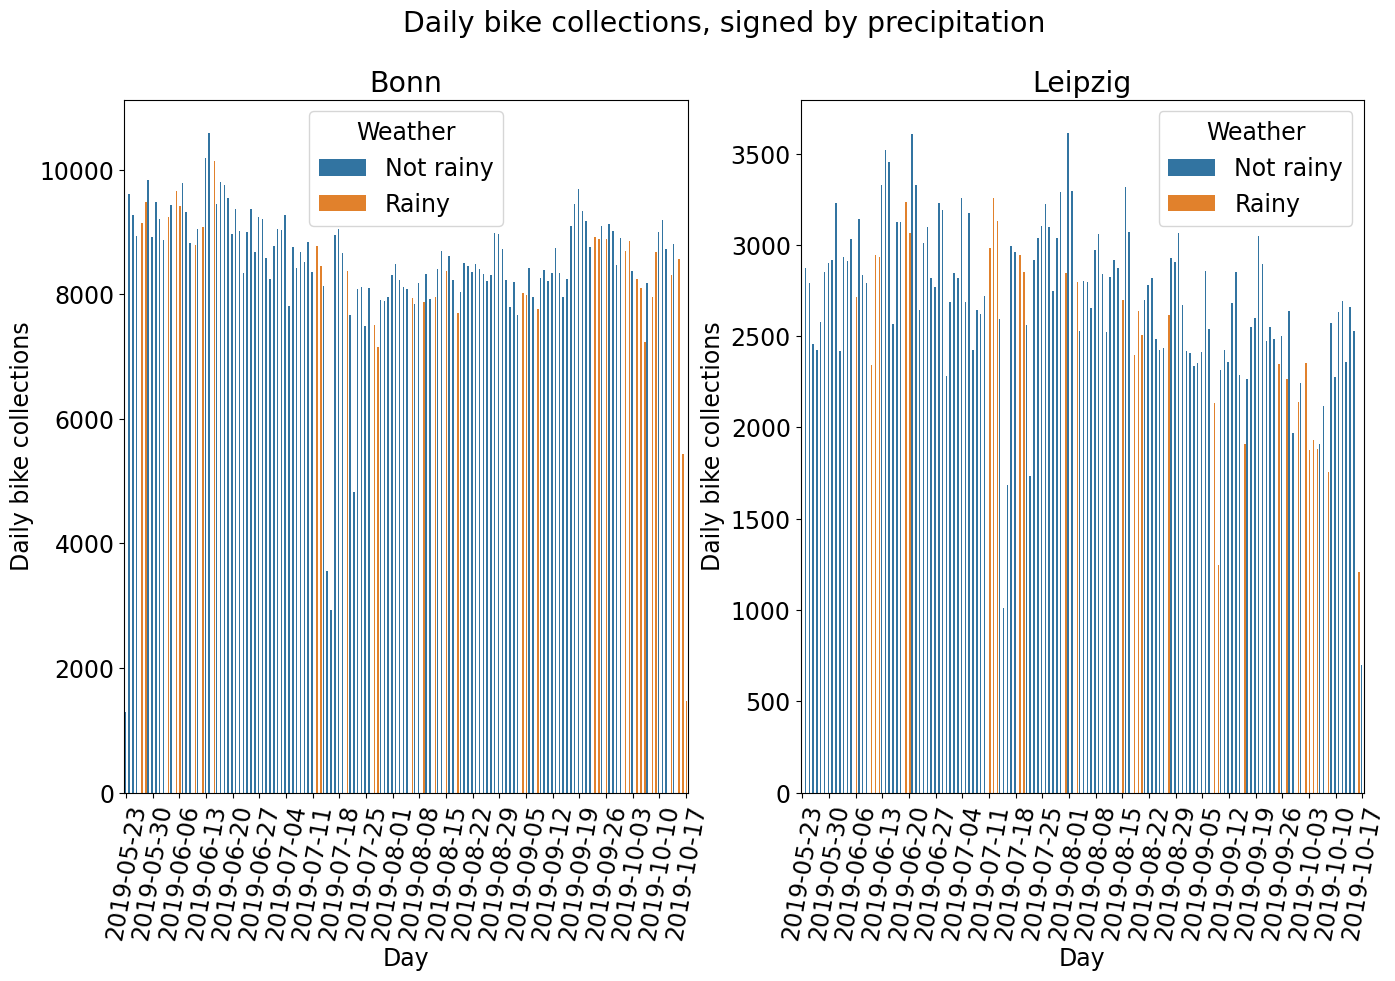

In [34]:
weather_comp_data = pd.concat((rainy_data_avg, sunny_data_avg)).reset_index().sort_values('timestamp')
weather_comp_data_city2 = pd.concat((rainy_data_avg_city2, sunny_data_avg_city2)).reset_index().sort_values('timestamp')

fig, ax = plt.subplots(1, 2)
sns.barplot(x='timestamp', y='collected', hue='Weather', data = weather_comp_data, ax = ax[0])
sns.barplot(x='timestamp', y='collected', hue='Weather', data = weather_comp_data_city2, ax = ax[1])
ax[0].set_ylabel('Daily bike collections')
ax[0].set_xlabel('Day')
ax[0].set_xticks(np.arange(len(weather_comp_data['timestamp']), step=7))
ax[0].set_title(f'{city}')
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=80)
ax[1].set_ylabel('Daily bike collections')
ax[1].set_xlabel('Day')
ax[1].set_xticks(np.arange(len(weather_comp_data_city2['timestamp']), step=7))
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=80)
ax[1].set_title(f'{city2}')
plt.suptitle('Daily bike collections, signed by precipitation')
plt.show()

The presented plots do not indicate that there is a significant dependency between the precipitation level and number of bike collections. One can see that the rain in October might be more influential on the users' choice than in July. This might be explained by the common impact of rain and temperature. The impact of rain in different parts of a week will be checked in the following part of notebook

Analoguous analysis for data collected from Nextbike API

In [35]:
rainy_data_avg_api, sunny_data_avg_api = weather_factor_impact(api_weather_data, api_data_valid, 'prcp')
rainy_data_avg_api['Weather'] = 'Rainy'
sunny_data_avg_api['Weather'] = 'Not rainy'

rainy_data_avg_api2, sunny_data_avg_api2 = weather_factor_impact(api_weather_data2, api_data_valid2, 'prcp')
rainy_data_avg_api2['Weather'] = 'Rainy'
sunny_data_avg_api2['Weather'] = 'Not rainy'

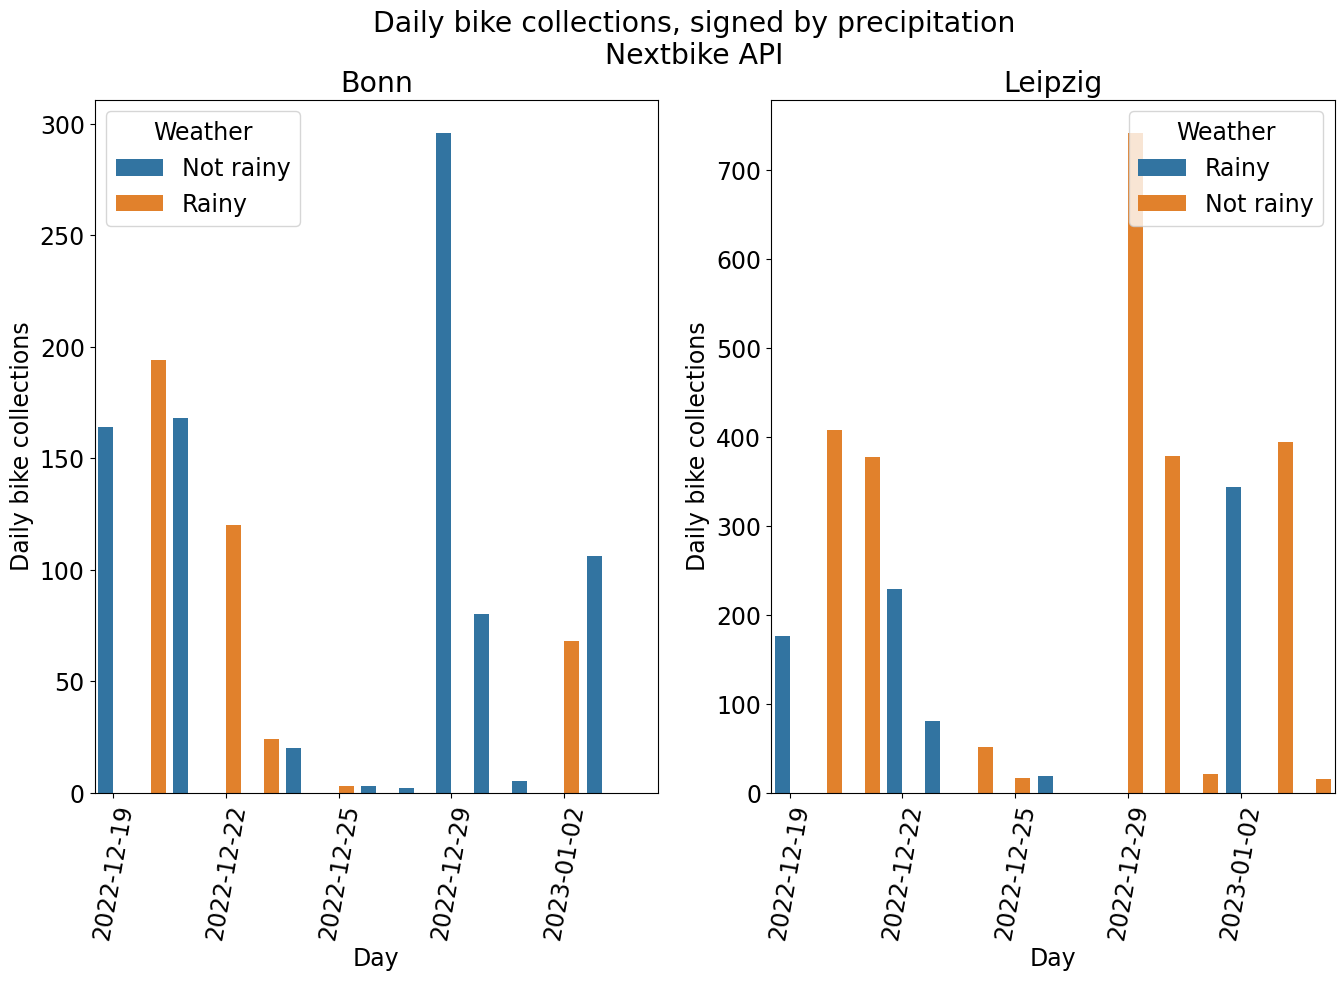

In [36]:
weather_comp_data_api = pd.concat((rainy_data_avg_api, sunny_data_avg_api)).reset_index().sort_values('timestamp')
weather_comp_data_api2 = pd.concat((rainy_data_avg_api2, sunny_data_avg_api2)).reset_index().sort_values('timestamp')

fig, ax = plt.subplots(1, 2)
sns.barplot(x='timestamp', y='collected', hue='Weather', data = weather_comp_data_api, ax = ax[0])
sns.barplot(x='timestamp', y='collected', hue='Weather', data = weather_comp_data_api2, ax = ax[1])
ax[0].set_ylabel('Daily bike collections')
ax[0].set_xlabel('Day')
ax[0].set_xticks(np.arange(len(weather_comp_data_api['timestamp']), step=3))
ax[0].set_title(f'{city}')
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=80)
ax[1].set_ylabel('Daily bike collections')
ax[1].set_xlabel('Day')
ax[1].set_xticks(np.arange(len(weather_comp_data_api2['timestamp']), step=3))
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=80)
ax[1].set_title(f'{city2}')
plt.suptitle('Daily bike collections, signed by precipitation\nNextbike API')
plt.show()

Those plots are very scattered, thus the conclusions may not be drawn, but anyway there is no reason to treat rainy days as ones with lower usage.

When compared with the previous plot, it is interesting that earlier bikes in Bonn were more likely rented than in Leipzig. In 2022/23 it is opposite.

#### Impact of wind speed

The analysis will be similar but for wind speed as factor.

In [37]:
windy_data_avg, calm_data_avg = weather_factor_impact(weather_city, df_city, 'wspd')
windy_data_avg['Weather'] = 'Windy'
calm_data_avg['Weather'] = 'Calm'

In [38]:
windy_data_avg_2, calm_data_avg_2 = weather_factor_impact(weather_df2, df2, 'wspd')
windy_data_avg_2['Weather'] = 'Windy'
calm_data_avg_2['Weather'] = 'Calm'

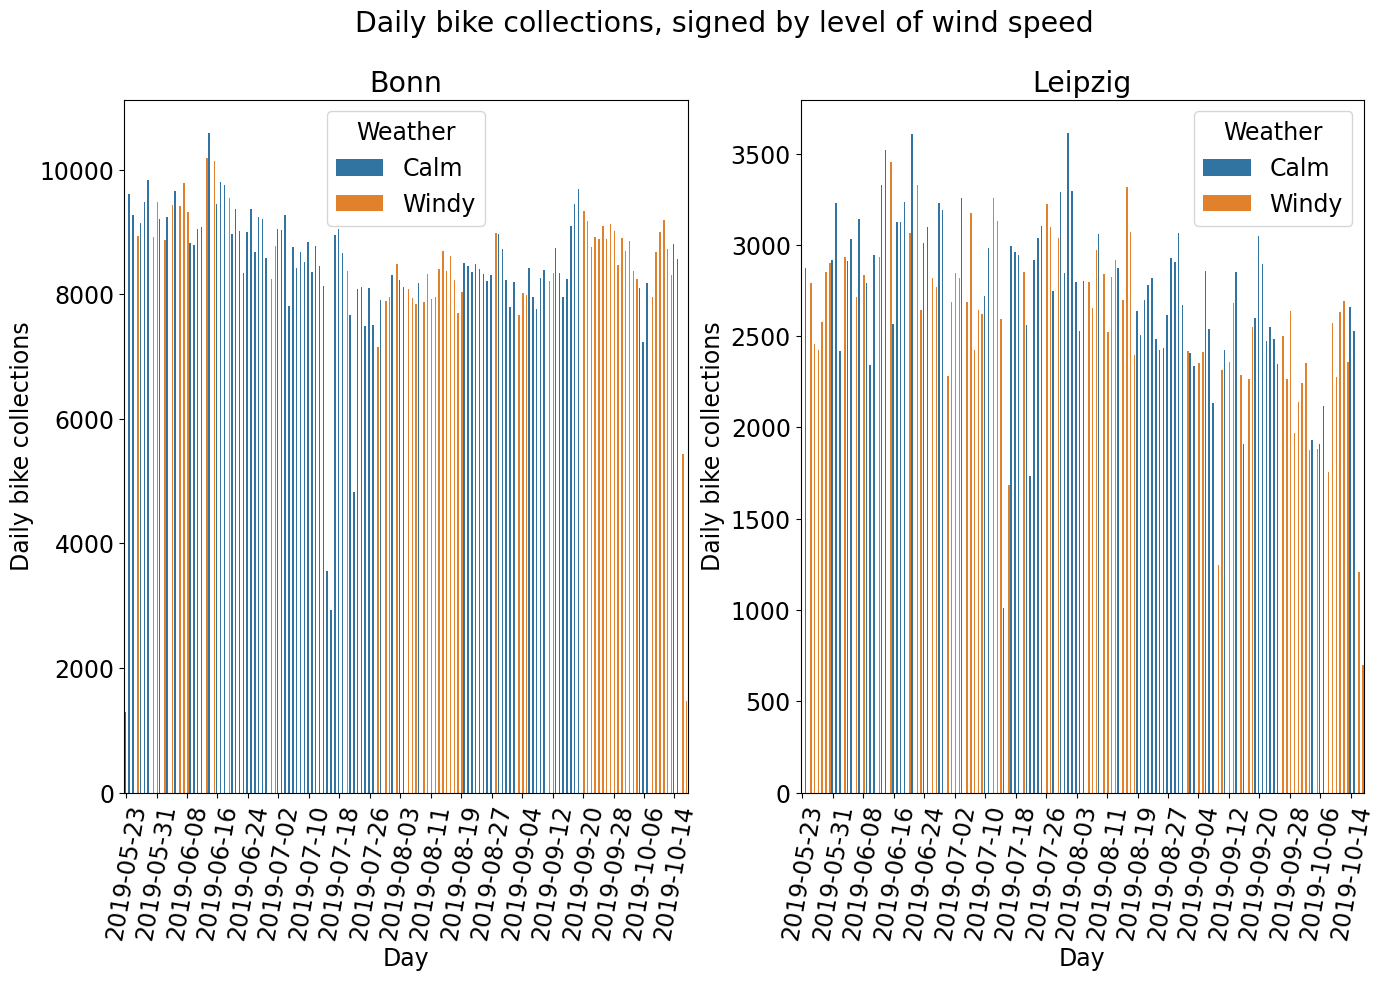

In [39]:
wind_comp_data = pd.concat((windy_data_avg, calm_data_avg)).reset_index().sort_values('timestamp')
wind_comp_data_2 = pd.concat((windy_data_avg_2, calm_data_avg_2)).reset_index().sort_values('timestamp')

fig, ax = plt.subplots(1, 2)
sns.barplot(x='timestamp', y='collected', hue='Weather', data = wind_comp_data, ax=ax[0], hue_order=['Calm', 'Windy'])
sns.barplot(x='timestamp', y='collected', hue='Weather', data = wind_comp_data_2, ax=ax[1], hue_order=['Calm', 'Windy'])
ax[0].set_ylabel('Daily bike collections')
ax[0].set_xlabel('Day')
ax[0].set_xticks(np.arange(len(weather_comp_data['timestamp']), step=8))
ax[0].set_title(city)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=80)
ax[1].set_ylabel('Daily bike collections')
ax[1].set_xlabel('Day')
ax[1].set_xticks(np.arange(len(weather_comp_data['timestamp']), step=8))
ax[1].set_title(city2)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=80)
plt.suptitle(f'Daily bike collections, signed by level of wind speed')
plt.show()

Similarly, days with heavy weather are not unambigously the ones with less bikes demand. It is interesting that the windy days are often grouped consecutively, especially in Bonn.  

#### Comparison of rain and collections for a given week

Another factor that might be influential on the bikes usage is the part of a week. The impact of precitipation level over the week on both data from 2019 and 2022/23 will be presented in the following part.

In [40]:
def get_week_analysis(start_date, end_date, df, weather_data):
    df_city_week = df.loc[(df.timestamp > start_date) & (df.timestamp < end_date)]
    weather_week = weather_data.loc[(weather_data['time'] > start_date) & (weather_data['time'] < end_date)]
    df_city_week_collections = df_city_week.groupby(df_city_week.timestamp.dt.strftime('%Y-%m-%d %H:00:00')).agg({'collected': 'sum'}).reset_index()
    df_city_week_collections['timestamp'] = pd.to_datetime(df_city_week_collections['timestamp'])
    week_analysis = weather_week.merge(df_city_week_collections, left_on='time', right_on='timestamp', how='left')
    return week_analysis

In [41]:
week_start = pd.to_datetime('2019-09-30')
week_end = pd.to_datetime('2019-10-07')

In [42]:
week_analysis = get_week_analysis(week_start, week_end, df_city, weather_city)

In [43]:
week_analysis_2 = get_week_analysis(week_start, week_end, df2, weather_df2)

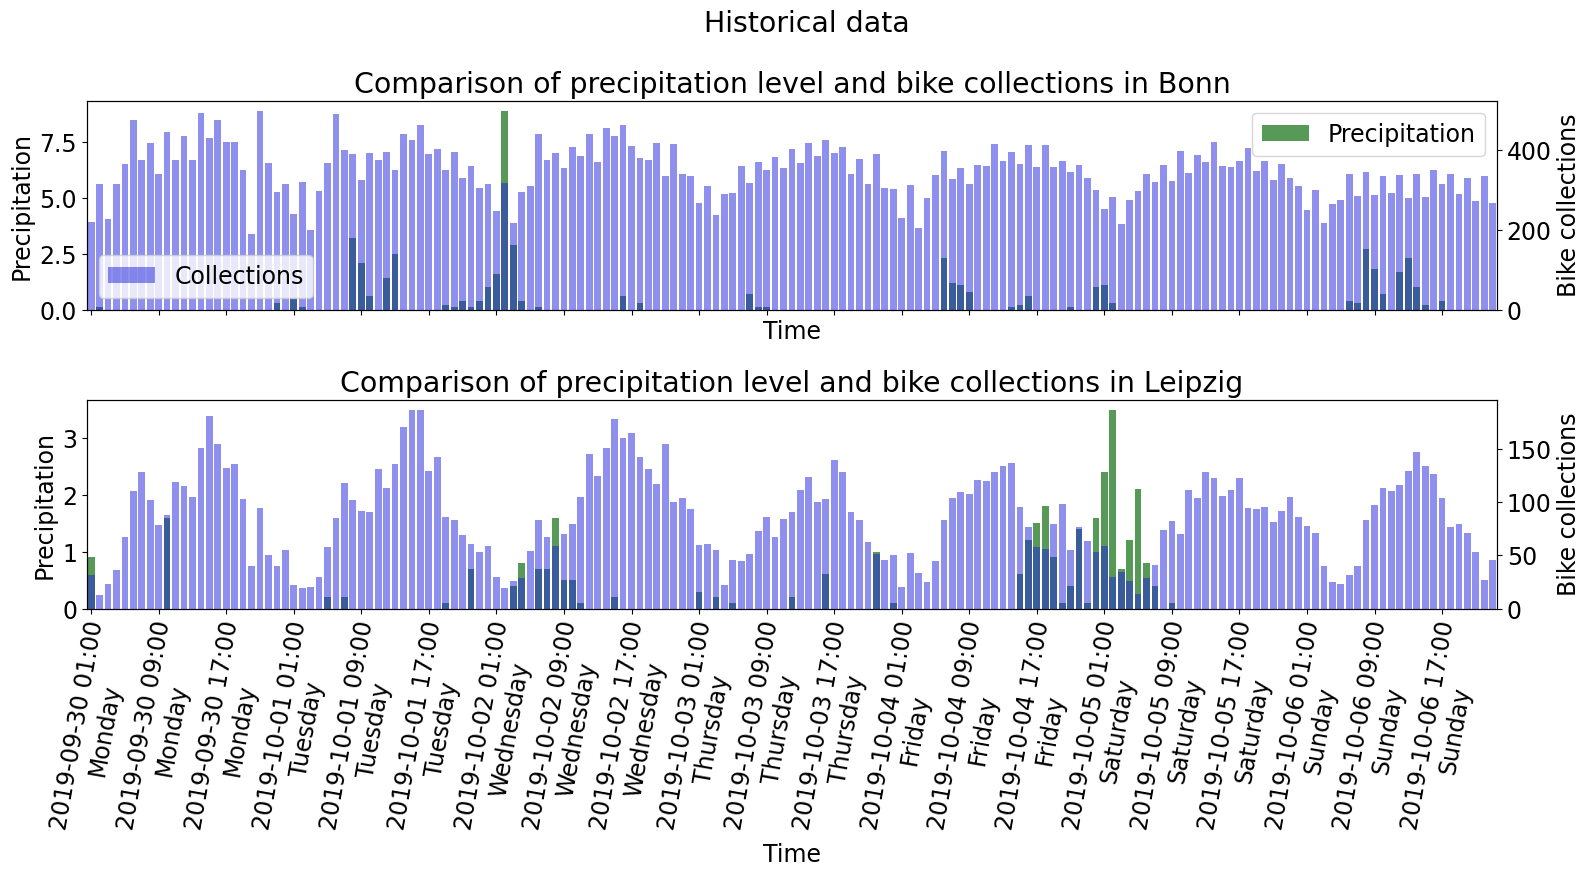

In [48]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax_1 = sns.barplot(x='time', y='prcp', data=week_analysis, color="g", alpha=0.7, label='Precipitation', ax=ax[0])
ax[0].set_ylabel('Precipitation')
ax[0].set_xlabel('Time')
ax[0].set_title(f'Comparison of precipitation level and bike collections in {city}')
ax_2 = ax_1.twinx()
sns.barplot(x='time', y='collected', data=week_analysis, ax=ax_2, color='b', alpha=0.5, label='Collections')
ax_2.set_ylabel('Bike collections')
ax_2.set_xticks(np.arange(len(week_analysis), step=8))
ax_2.set_xticklabels(week_analysis['time'].dt.strftime('%Y-%m-%d %H:%M').tolist()[::8])
ax[0].legend(loc=1)
ax_2.legend(loc=3)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=80)

ax_3 = sns.barplot(x='time', y='prcp', data=week_analysis_2, color="g", alpha=0.7, label='Precipitation', ax=ax[1])
ax[1].set_ylabel('Precipitation')
ax[1].set_xlabel('Time')
ax_4 = ax_3.twinx()
sns.barplot(x='time', y='collected', data=week_analysis_2, ax=ax_4, color='b', alpha=0.5, label='Collections')
ax_4.set_ylabel('Bike collections')
ax_4.set_xticks(np.arange(len(week_analysis_2), step=8))
ax_4.set_xticklabels(
    (week_analysis_2['time'].dt.strftime('%Y-%m-%d %H:%M') + '\n' + week_analysis_2['time'].dt.day_name()).tolist()[::8])
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=80)

ax[1].set_title(f'Comparison of precipitation level and bike collections in {city2}')
plt.suptitle("Historical data")
fig.tight_layout()
plt.show()

Not that heavy rain on Wednesday, 02.10.2019 in Leipzig resulted in a less demand in the morning. On the other hand, night rains did not result in lower demand on bikes.

Similar analysis for data from Nextbike API

In [45]:
week_start_api = pd.to_datetime('2022-12-19')
week_end_api = pd.to_datetime('2022-12-27')
week_analysis_api = get_week_analysis(week_start_api, week_end_api, api_data_valid, api_weather_data)
week_analysis_api2 = get_week_analysis(week_start_api, week_end_api, api_data_valid2, api_weather_data2)

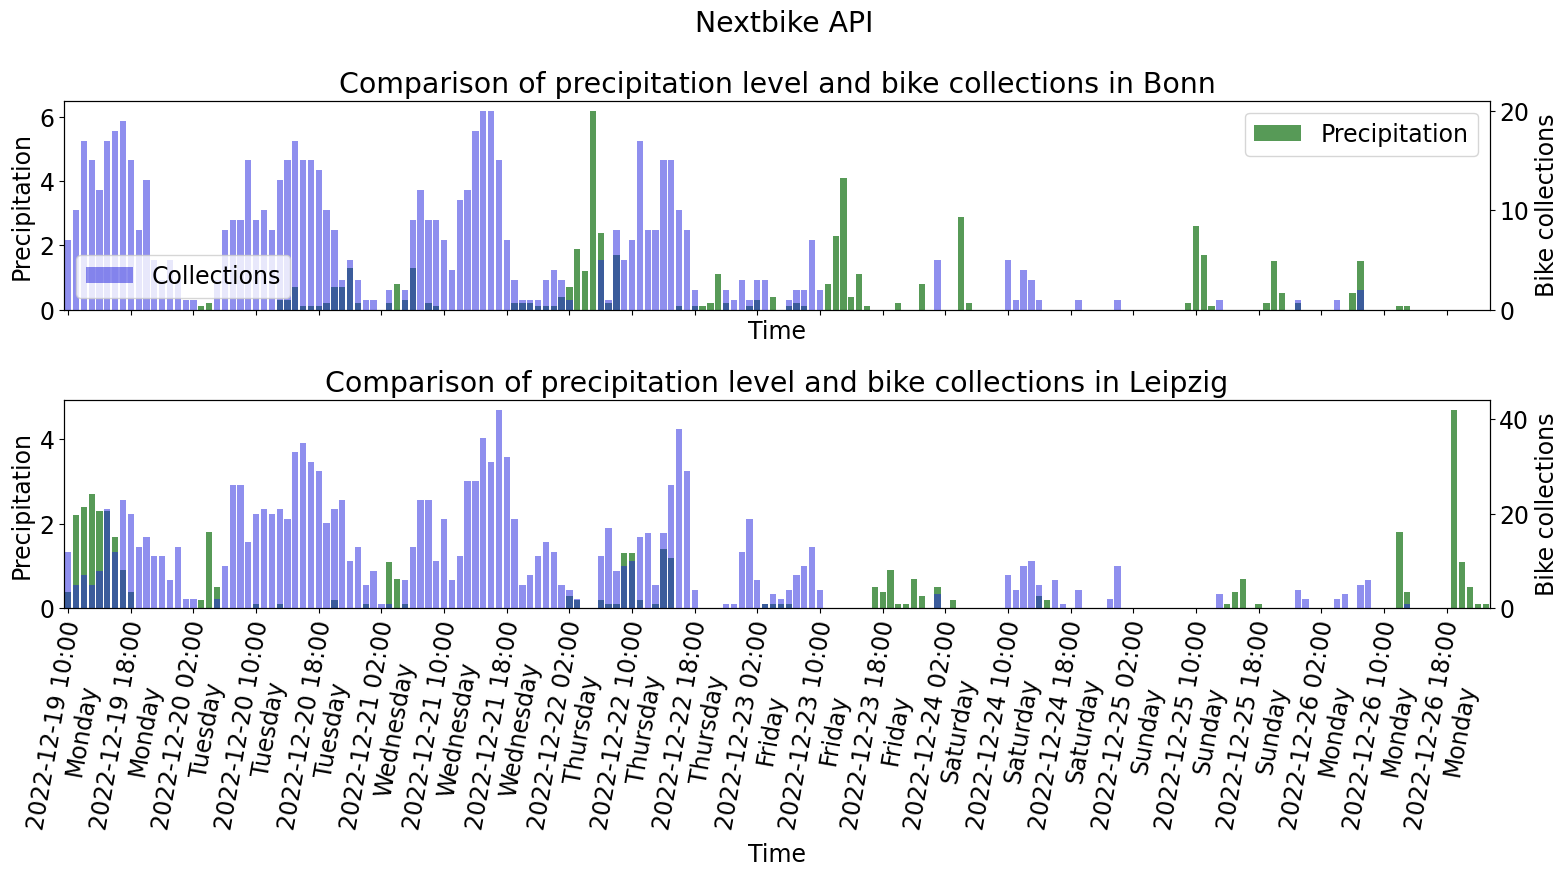

In [47]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax_1 = sns.barplot(x='time', y='prcp', data=week_analysis_api, color="g", alpha=0.7, label='Precipitation', ax=ax[0])
ax[0].set_ylabel('Precipitation')
ax[0].set_xlabel('Time')
ax[0].set_title(f'Comparison of precipitation level and bike collections in {city}')
ax_2 = ax_1.twinx()
sns.barplot(x='time', y='collected', data=week_analysis_api, ax=ax_2, color='b', alpha=0.5, label='Collections')
ax_2.set_ylabel('Bike collections')
ax_2.set_xticks(np.arange(len(week_analysis_api), step=8))
ax_2.set_xticklabels(week_analysis_api['time'].dt.strftime('%Y-%m-%d %H:%M').tolist()[::8])
ax[0].legend(loc=1)
ax_2.legend(loc=3)
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=80)

ax_3 = sns.barplot(x='time', y='prcp', data=week_analysis_api2, color="g", alpha=0.7, label='Precipitation', ax=ax[1])
ax[1].set_ylabel('Precipitation')
ax[1].set_xlabel('Time')
ax_4 = ax_3.twinx()
sns.barplot(x='time', y='collected', data=week_analysis_api2, ax=ax_4, color='b', alpha=0.5, label='Collections')
ax_4.set_ylabel('Bike collections')
ax_4.set_xticks(np.arange(len(week_analysis_api2), step=8))
ax_4.set_xticklabels(
    (week_analysis_api2['time'].dt.strftime('%Y-%m-%d %H:%M') + '\n' + week_analysis_api2['time'].dt.day_name()).tolist()[::8])
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=80)

ax[1].set_title(f'Comparison of precipitation level and bike collections in {city2}')
plt.suptitle("Nextbike API")
fig.tight_layout()
plt.show()

In December, the bikes were almost never collected while it was raining. The rain, in addition to low temperature, makes the bike sharing system idle.  